In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import os, sys
import time
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import lib
import torch, torch.nn as nn
import torch.nn.functional as F
from qhoptim.pyt import QHAdam

device = 'cuda' if torch.cuda.is_available() else 'cpu'

experiment_name = 'protein_odst_deep'
experiment_name = '{}_{}.{:0>2d}.{:0>2d}_{:0>2d}:{:0>2d}'.format(experiment_name, *time.gmtime()[:5])
print("experiment:", experiment_name)

env: CUDA_VISIBLE_DEVICES=1
experiment: protein_odst_deep_2019.05.23_10:40


In [2]:
data = lib.Dataset("PROTEIN", random_state=1337, quantile_transform=True, quantile_noise=1e-3)
num_features = data.X_train.shape[1]
num_classes = len(set(data.y_train))

model = nn.Sequential(
    lib.DenseBlock(num_features, 512, num_layers=2, tree_dim=num_classes, depth=6,
                   flatten_output=False, input_dropout=0.5),
    lib.Lambda(lambda x: x.mean(dim=-2)),   # mean over trees, first 3 columns
    
).to(device)

with torch.no_grad():
    res = model(torch.as_tensor(data.X_train[:5000], device=device))
    # trigger data-aware init
    
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)


trainer = lib.Trainer(
    model=model, loss_function=F.cross_entropy,
    experiment_name=experiment_name,
    warm_start=False,
    Optimizer=QHAdam,
    optimizer_params=dict(nus=(0.7, 1.0), betas=(0.95, 0.998)),
    verbose=True,
    n_last_checkpoints=5
)

In [3]:
from tqdm import tqdm
from IPython.display import clear_output
loss_history, err_history = [], []
best_val_error = 1
best_step = 0
early_stopping_rounds = 7000
report_frequency = 100

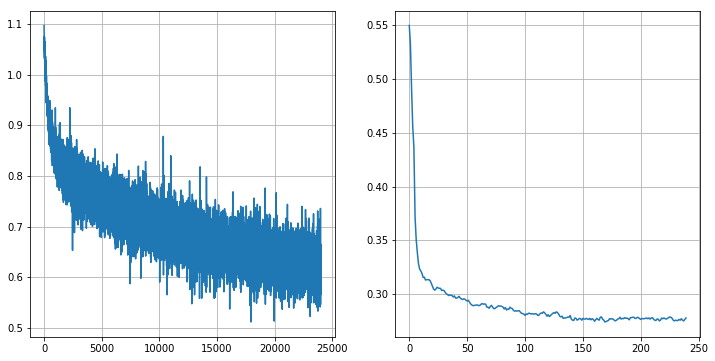

Loss 0.56601
Val Error rate: 0.27795
BREAK. There is no improvment for 7000 steps
Best step:  17000
Best Val Error rate: 0.27425


In [4]:
for batch in lib.iterate_minibatches(data.X_train, data.y_train, batch_size=512, 
                                                shuffle=True, epochs=float('inf')):
    metrics = trainer.train_on_batch(*batch, device=device)
    
    loss_history.append(metrics['loss'])

    if trainer.step % report_frequency == 0:
        trainer.save_checkpoint()
        trainer.average_checkpoints(out_tag='avg')
        trainer.load_checkpoint(tag='avg')
        error_rate = trainer.evaluate_classification_error(
            data.X_valid, data.y_valid, device=device, batch_size=1024)
        
        if error_rate < best_val_error:
            best_val_error = error_rate
            best_step = trainer.step
            trainer.save_checkpoint(tag='best')
        
        err_history.append(error_rate)
        trainer.load_checkpoint()  # last
        trainer.remove_old_temp_checkpoints()
            
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.subplot(1, 2, 1)
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(1,2,2)
        plt.plot(err_history)
        plt.grid()
        plt.show()
        print("Loss %.5f" % (metrics['loss']))
        print("Val Error rate: %0.5f" % (error_rate))
        
    if trainer.step > best_step + early_stopping_rounds:
        print('BREAK. There is no improvment for {} steps'.format(early_stopping_rounds))
        print("Best step: ", best_step)
        print("Best Val Error rate: %0.5f" % (best_val_error))
        break

In [5]:
trainer.load_checkpoint(tag='best')
model.train(False)
error_rate = trainer.evaluate_classification_error(data.X_test, data.y_test, device=device, batch_size=512)
print('Best step: ', trainer.step)
print("Test Error rate: %0.5f" % (error_rate))

Loaded logs/protein_odst_deep_2019.05.23_10:40/checkpoint_best.pth
Best step:  17000
Test Error rate: 0.27503
